### The classification threshold makes a difference!
(a.k.a. The reason why you use .predict_proba() instead of .predict() in classification.)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

In [2]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

In [3]:
X[:5]

array([[-1.04948638,  0.8786438 ],
       [ 0.8780991 ,  0.89551051],
       [ 0.95928819,  1.03967316],
       [-1.18013412,  1.12062155],
       [-0.90731836,  1.06040861]])

In [4]:
y[:5]

array([1, 0, 0, 1, 1])

In [5]:
# subset by 0 and 1 class - important for plotting
mask_c0 = y == 0
mask_c1 = ~mask_c0
print("mask_c0\tmask_c1")
for i in range(10):
    print(f"{mask_c0[i]}\t{mask_c1[i]}")

mask_c0	mask_c1
False	True
True	False
True	False
False	True
False	True
False	True
True	False
False	True
True	False
False	True


In [6]:
def plot_two_classes(X, y, coeffs=None, p=None):
    '''Plots binary classes in X and y  and plots
       the decision boundary at the given decision
       boundary if coefficients are given
    '''
    mask_c0 = y == 0
    mask_c1 = ~mask_c0
    X_c0, y_c0 = X[mask_c0], y[mask_c0]
    X_c1, y_c1 = X[mask_c1], y[mask_c1]
    
    # for plot limits
    x1_mn, x1_mx = min(X[:,0]), max(X[:,0])
    x2_mn, x2_mx = min(X[:,1]), max(X[:,1])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    ax.plot(X_c0[:,0], X_c0[:,1],
            marker='o',
            linewidth=0,
            markerfacecolor='black',
            markeredgecolor='black',
            markeredgewidth=1,
            markersize=8,
            label='class 0')
    ax.plot(X_c1[:,0], X_c1[:,1], 
            marker='o',
            linewidth=0,
            markerfacecolor='white',
            markeredgecolor='black',
            markeredgewidth=1,
            markersize=8,
            label='class 1')
    # plot decision boundary at given probability, p
    # ln(p/1-p) = B0 + B1*x1 + B2*X2
    if coeffs is not None:
        B0, B1, B2 = coeffs[0], coeffs[1], coeffs[2]
        x2_minx1 = (np.log(p/(1 - p)) - B0 - B1 * x1_mn) / B2
        x2_maxx1 = (np.log(p/(1 - p)) - B0 - B1 * x1_mx) / B2
        db = np.array([[x1_mn, x2_minx1],
                       [x1_mx, x2_maxx1]])
        label = f"decision boundary at p={p}"
        ax.plot(db[:,0], db[:,1], 'r-', label=label)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

    ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center left")
    buffer = 0.5
    ax.set_xlim([x1_mn - buffer, x1_mx + buffer])
    ax.set_ylim([x2_mn - buffer, x2_mx + buffer])

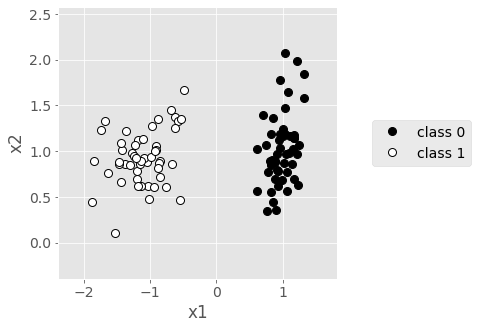

In [7]:
plot_two_classes(X, y)

In [8]:
# add some noise
rng = np.random.RandomState(2)
X += 4 * rng.uniform(size=X.shape)

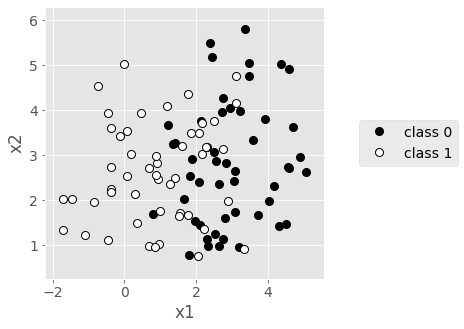

In [9]:
plot_two_classes(X, y)

### Now our dataset is sufficiently messy - will be nearly impossible to get perfect performance.

In [10]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

In [11]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [12]:
y_test_pred = clf.predict(X_test)
y_test_pred[:10]

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

### Let's see the coefficients that were fit in the logistic regression

The logistic regression equation:
\begin{equation}
\ln \left( \frac{p}{1-p} \right)  = \beta_0 + \beta_1 X_1 + \beta_2 X_2\\
\end{equation}

In [13]:
print(clf.intercept_)  # the intercept B0
print(clf.coef_) # the coefficients B1 and B2
coeffs = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])
print("\nThe coefficients:")
print("   B0       B1       B2")
betas = "   ".join(str(val.round(4)) for val in coeffs)
print(betas)

[1.6497325]
[[-1.43974104  0.36174421]]

The coefficients:
   B0       B1       B2
1.6497   -1.4397   0.3617


In [14]:
def print_recall_and_precision(y_true, y_pred, threshold=0.5):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    print(f"Recall: {recall:0.3f} using {threshold} threshold.")
    print(f"Precision: {precision:0.3f} using {threshold} threshold.")

In [15]:
print_recall_and_precision(y_test, y_test_pred)

Recall: 0.682 using 0.5 threshold.
Precision: 0.833 using 0.5 threshold.


### Yes the above code worked, but you almost NEVER want to simply call .predict() on a trained classifier.  Don't you want to control the threshold?!?

In [16]:
y_test_pred_prob = clf.predict_proba(X_test)[:,1]
y_test_pred_prob[:10]

array([0.84460428, 0.96996592, 0.04276017, 0.22008273, 0.05554921,
       0.03109826, 0.78814464, 0.01798065, 0.06874038, 0.73207994])

In [17]:
threshold = 0.5
y_test_pred = (y_test_pred_prob >= threshold).astype(int)
y_test_pred[:10]

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [18]:
# Get the coefficients
coeffs = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])
print(coeffs)

[ 1.6497325  -1.43974104  0.36174421]


In [19]:
print_recall_and_precision(y_test, y_test_pred, threshold)

Recall: 0.682 using 0.5 threshold.
Precision: 0.833 using 0.5 threshold.


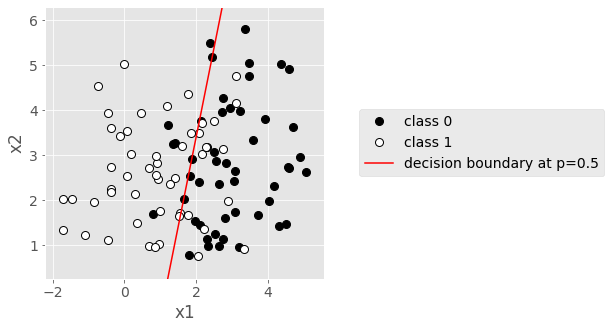

In [20]:
# plot with the threshold that defines the decision boundary
plot_two_classes(X, y, coeffs=coeffs, p=threshold)

### Same results as before, but now we can vary the threshold to maximize whatever metric we want

In [21]:
threshold = 0.2
y_test_pred = (y_test_pred_prob >= threshold).astype(int)
print_recall_and_precision(y_test, y_test_pred, threshold)

Recall: 0.909 using 0.2 threshold.
Precision: 0.667 using 0.2 threshold.


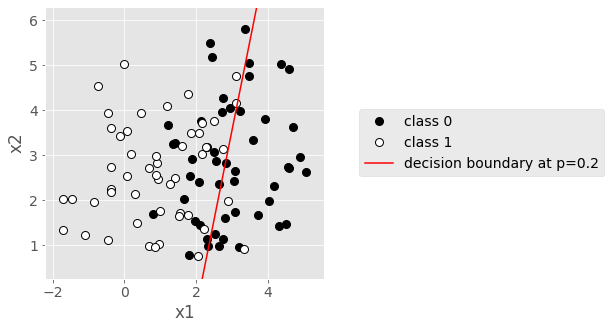

In [22]:
plot_two_classes(X, y, coeffs=coeffs, p=threshold)

In [23]:
threshold = 0.8
y_test_pred = (y_test_pred_prob >= threshold).astype(int)
print_recall_and_precision(y_test, y_test_pred, threshold)

Recall: 0.364 using 0.8 threshold.
Precision: 1.000 using 0.8 threshold.


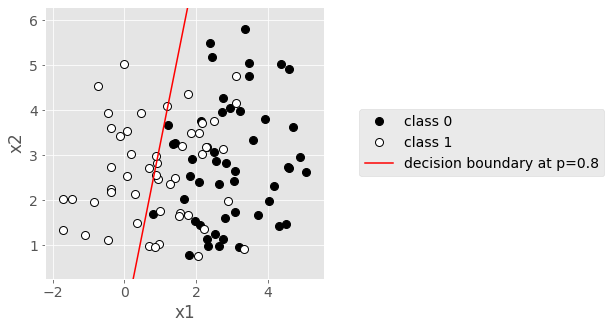

In [24]:
plot_two_classes(X, y, coeffs=coeffs, p=threshold)

### Take-away
From a fit classification model, you can alter the classification threshold to optimize for the metric you care about.  Do not simply report "My best recall using Logistic Regression was 0.6" without mentioning the threshold it occurred at.